In [9]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
from __future__ import print_function

%matplotlib inline

import collections
import math
import numpy as np
import os
import random
import tensorflow as tf
import zipfile
from matplotlib import pylab
from six.moves import range
from six.moves.urllib.request import urlretrieve
from sklearn.manifold import TSNE


In [10]:
# If the text8 dataset data are not already available, then this code will download it.
url = 'http://mattmahoney.net/dc/'

def maybe_download(filename, expected_bytes):
  """Download a file if not present, and make sure it's the right size."""
  if not os.path.exists(filename):
    filename, _ = urlretrieve(url + filename, filename)
  statinfo = os.stat(filename)
  if statinfo.st_size == expected_bytes:
    print('Found and verified %s' % filename)
  else:
    print(statinfo.st_size)
    raise Exception(
      'Failed to verify ' + filename + '. Can you get to it with a browser?')
  return filename

filename = maybe_download('text8.zip', 31344016)

Found and verified text8.zip


In [11]:
# This code reads the above downloaded data in filename into a string
def read_data(filename):
  """Extract the first file enclosed in a zip file as a list of words"""
  with zipfile.ZipFile(filename) as f:
    data = tf.compat.as_str(f.read(f.namelist()[0])).split()
  return data
  
words = read_data(filename)
print('Data size %d' % len(words))

Data size 17005207


In [12]:
# This code builds the datset into a dictionary and replaces rare words with an 'UNK' token
vocabulary_size = 50000

def build_dataset(words):
  count = [['UNK', -1]]
  count.extend(collections.Counter(words).most_common(vocabulary_size - 1))
  dictionary = dict()
  for word, _ in count:
    dictionary[word] = len(dictionary)
  data = list()
  unk_count = 0
  for word in words:
    if word in dictionary:
      index = dictionary[word]
    else:
      index = 0  # dictionary['UNK']
      unk_count = unk_count + 1
    data.append(index)
  count[0][1] = unk_count
  reverse_dictionary = dict(zip(dictionary.values(), dictionary.keys())) 
  return data, count, dictionary, reverse_dictionary

data, count, dictionary, reverse_dictionary = build_dataset(words)
print('Most common words (+UNK)', count[:5])
print('Sample data', data[:10])
del words  # Hint to reduce memory.

Most common words (+UNK) [['UNK', 418391], ('the', 1061396), ('of', 593677), ('and', 416629), ('one', 411764)]
Sample data [5234, 3081, 12, 6, 195, 2, 3134, 46, 59, 156]


In [24]:
# This generates a training batch for the skip-gram model
data_index = 0

def generate_batch(batch_size, num_skips, skip_window):
  global data_index
  assert batch_size % num_skips == 0
  assert num_skips <= 2 * skip_window
  batch = np.ndarray(shape=(batch_size), dtype=np.int32)
  labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32)
  span = 2 * skip_window + 1 # [ skip_window target skip_window ]
  buffer = collections.deque(maxlen=span)
  for _ in range(span):
    buffer.append(data[data_index])
    data_index = (data_index + 1) % len(data)
    
  for i in range(batch_size // num_skips):
    target = skip_window  # target label at the center of the buffer
    targets_to_avoid = [ skip_window ]
    for j in range(num_skips):
      while target in targets_to_avoid:
        target = random.randint(0, span - 1)
      targets_to_avoid.append(target)
      batch[i * num_skips + j] = buffer[skip_window]
      labels[i * num_skips + j, 0] = buffer[target]
    buffer.append(data[data_index])
    data_index = (data_index + 1) % len(data)
  return batch, labels

print('data:', [reverse_dictionary[di] for di in data[:8]])

for num_skips, skip_window in [(2, 1), (4, 2)]:
    data_index = 0
    batch, labels = generate_batch(batch_size=8, num_skips=num_skips, skip_window=skip_window)
    print('\nwith num_skips = %d and skip_window = %d:' % (num_skips, skip_window))
    print('    batch:', [reverse_dictionary[bi] for bi in batch])
    print('    labels:', [reverse_dictionary[li] for li in labels.reshape(8)])

data: ['anarchism', 'originated', 'as', 'a', 'term', 'of', 'abuse', 'first']
3
4
5
6

with num_skips = 2 and skip_window = 1:
    batch: ['originated', 'originated', 'as', 'as', 'a', 'a', 'term', 'term']
    labels: ['anarchism', 'as', 'originated', 'a', 'as', 'term', 'a', 'of']
5
6

with num_skips = 4 and skip_window = 2:
    batch: ['as', 'as', 'as', 'as', 'a', 'a', 'a', 'a']
    labels: ['originated', 'term', 'a', 'anarchism', 'originated', 'of', 'term', 'as']


In [18]:
# Trains the skip-gram model
batch_size = 128
embedding_size = 128 # Dimension of the embedding vector.
skip_window = 1 # How many words to consider left and right.
num_skips = 2 # How many times to reuse an input to generate a label.
# We pick a random validation set to sample nearest neighbors. here we limit the
# validation samples to the words that have a low numeric ID, which by
# construction are also the most frequent. 
valid_size = 16 # Random set of words to evaluate similarity on.
valid_window = 100 # Only pick dev samples in the head of the distribution.
valid_examples = np.array(random.sample(range(valid_window), valid_size))
num_sampled = 64 # Number of negative examples to sample.

graph = tf.Graph()

with graph.as_default(), tf.device('/cpu:0'):

  # Input data.
  train_dataset = tf.placeholder(tf.int32, shape=[batch_size])
  train_labels = tf.placeholder(tf.int32, shape=[batch_size, 1])
  valid_dataset = tf.constant(valid_examples, dtype=tf.int32)
  
  # Variables.
  embeddings = tf.Variable(
    tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0))
  softmax_weights = tf.Variable(
    tf.truncated_normal([vocabulary_size, embedding_size],
                         stddev=1.0 / math.sqrt(embedding_size)))
  softmax_biases = tf.Variable(tf.zeros([vocabulary_size]))
  
  # Model.
  # Look up embeddings for inputs.
  embed = tf.nn.embedding_lookup(embeddings, train_dataset)
  # Compute the softmax loss, using a sample of the negative labels each time.
  loss = tf.reduce_mean(
    tf.nn.sampled_softmax_loss(weights=softmax_weights, biases=softmax_biases, inputs=embed,
                               labels=train_labels, num_sampled=num_sampled, num_classes=vocabulary_size))

  # Optimizer.
  # Note: The optimizer will optimize the softmax_weights AND the embeddings.
  # This is because the embeddings are defined as a variable quantity and the
  # optimizer's `minimize` method will by default modify all variable quantities 
  # that contribute to the tensor it is passed.
  # See docs on `tf.train.Optimizer.minimize()` for more details.
  optimizer = tf.train.AdagradOptimizer(1.0).minimize(loss)
  
  # Compute the similarity between minibatch examples and all embeddings.
  # We use the cosine distance:
  norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keepdims=True))
  normalized_embeddings = embeddings / norm
  valid_embeddings = tf.nn.embedding_lookup(
    normalized_embeddings, valid_dataset)
  similarity = tf.matmul(valid_embeddings, tf.transpose(normalized_embeddings))

In [19]:
# Train the model and evaluate by printing 8 nearest words to a given word.

num_steps = 100001

with tf.Session(graph=graph) as session:
  tf.global_variables_initializer().run()
  print('Initialized')
  average_loss = 0
  for step in range(num_steps):
    batch_data, batch_labels = generate_batch(
      batch_size, num_skips, skip_window)
    feed_dict = {train_dataset : batch_data, train_labels : batch_labels}
    _, l = session.run([optimizer, loss], feed_dict=feed_dict)
    average_loss += l
    if step % 2000 == 0:
      if step > 0:
        average_loss = average_loss / 2000
      # The average loss is an estimate of the loss over the last 2000 batches.
      print('Average loss at step %d: %f' % (step, average_loss))
      average_loss = 0
    # note that this is expensive (~20% slowdown if computed every 500 steps)
    if step % 10000 == 0:
      sim = similarity.eval()
      for i in range(valid_size):
        valid_word = reverse_dictionary[valid_examples[i]]
        top_k = 8 # number of nearest neighbors
        nearest = (-sim[i, :]).argsort()[1:top_k+1]
        log = 'Nearest to %s:' % valid_word
        for k in range(top_k):
          close_word = reverse_dictionary[nearest[k]]
          log = '%s %s,' % (log, close_word)
        print(log)
  final_embeddings = normalized_embeddings.eval()

Initialized
Average loss at step 0: 8.167164
Nearest to seven: specially, bulgar, bosco, beecher, whitby, slovakia, siblings, alomar,
Nearest to for: carew, aznar, partnered, artform, concurrency, stabilizer, logbook, heinemann,
Nearest to while: gollancz, moe, maggots, rousseau, dualism, endosymbiotic, carloman, staunch,
Nearest to there: infimum, hamsun, realisation, invasions, indigenous, petroleum, institutional, criminals,
Nearest to their: kol, nieces, sulla, apl, bacteriophage, looms, sodom, powerplant,
Nearest to states: patenting, rushed, aachen, aaliyah, frustration, unites, italo, northeastern,
Nearest to a: plenary, gielgud, ncia, seal, optimization, swampy, kossuth, scottsdale,
Nearest to was: intensity, remain, sections, intercepts, ap, rub, wingers, corcovado,
Nearest to these: huey, abbott, nitrous, clandestinely, theorized, gravitational, sunda, benzoyl,
Nearest to about: stray, aviator, batcave, azure, bluebeard, mckinney, mears, belzec,
Nearest to UNK: dacko, maharal

Average loss at step 52000: 3.444611
Average loss at step 54000: 3.445236
Average loss at step 56000: 3.426861
Average loss at step 58000: 3.397893
Average loss at step 60000: 3.321200
Nearest to seven: eight, six, four, five, nine, three, zero, two,
Nearest to for: after, during, pergamon, when, against, of, by, carew,
Nearest to while: although, after, when, before, but, however, though, tracked,
Nearest to there: they, it, he, she, still, we, often, also,
Nearest to their: its, his, her, your, our, the, some, several,
Nearest to states: state, nations, kingdom, tarmac, aspires, countries, commonality, modulo,
Nearest to a: the, another, millennialism, guesses, hillsides, gielgud, acme, swampy,
Nearest to was: is, were, has, had, became, been, be, but,
Nearest to these: many, several, some, both, those, various, such, all,
Nearest to about: seven, dwindling, recorded, over, mild, pounding, ammonius, on,
Nearest to UNK: roundhouse, derailleur, clemency, zee, hawai, nat, honorary, mouv

In [20]:
# Use t-SNE to reduce the dimensionality of the output down to 2D so that it is easily visualizable
num_points = 400

tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000, method='exact')
two_d_embeddings = tsne.fit_transform(final_embeddings[1:num_points+1, :])

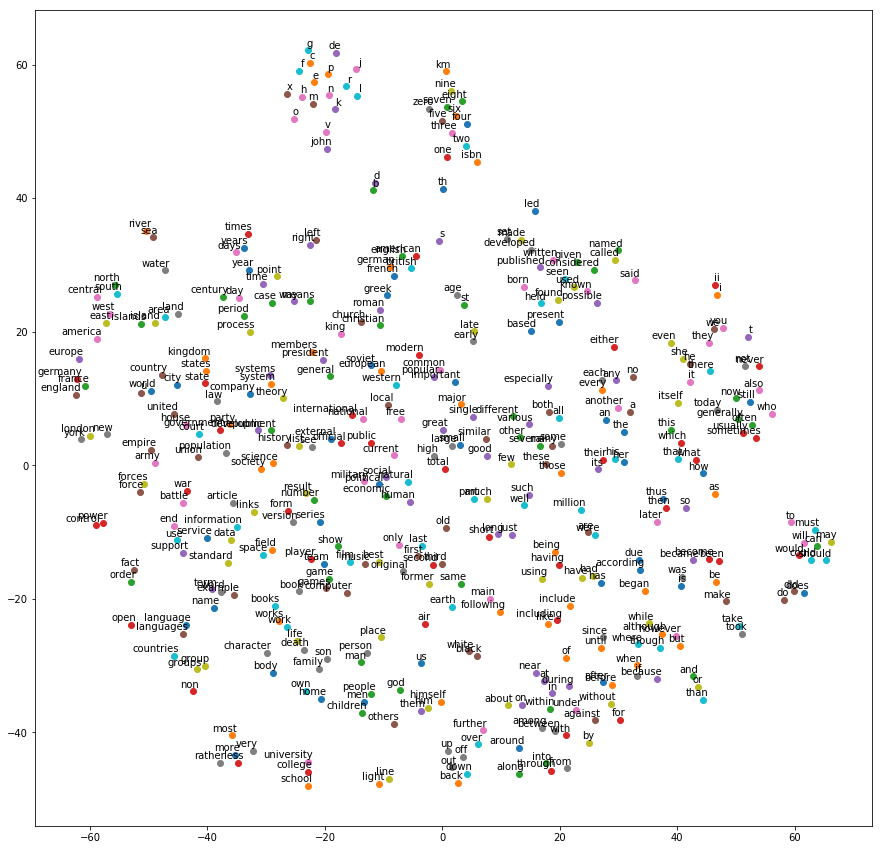

In [21]:
# Plot the 2D output after performing t-SNE
def plot(embeddings, labels):
  assert embeddings.shape[0] >= len(labels), 'More labels than embeddings'
  pylab.figure(figsize=(15,15))  # in inches
  for i, label in enumerate(labels):
    x, y = embeddings[i,:]
    pylab.scatter(x, y)
    pylab.annotate(label, xy=(x, y), xytext=(5, 2), textcoords='offset points',
                   ha='right', va='bottom')
  pylab.show()

words = [reverse_dictionary[i] for i in range(1, num_points+1)]
plot(two_d_embeddings, words)

In [42]:
# This generates a training batch for the CBOW model. Unlike the skip-gram model, this takes a word's
# context as input and predicts the word as output.
data_index = 0

def generate_batch_CBOW(batch_size, skip_window):
  global data_index
  span = 2 * skip_window + 1 # [ skip_window target skip_window ]
  # The batch data must take this shape since every element is now a vector that is 2 * skip_window in size
  # eg. if we have sentence 'Welcome to Wakanda', and a skip_window of 1 on the label 'to', we would want the 
  # training batch to contain ['Welcome', 'Wakanda']
  batch = np.ndarray(shape=(batch_size, 2 * skip_window), dtype=np.int32)
  labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32)
  buffer = collections.deque(maxlen=span)

  for _ in range(span):
    buffer.append(data[data_index])
    data_index = (data_index + 1) % len(data)
    
  for i in range(batch_size):
    list_form = list(buffer)
    curr_label = list_form.pop(skip_window)
    batch[i] = list_form
    labels[i, 0] = curr_label
    buffer.append(data[data_index])
    data_index = (data_index + 1) % len(data)
  return batch, labels

print('data:', [reverse_dictionary[di] for di in data[:8]])

for skip_window in [1, 2]:
    data_index = 0
    batch, labels = generate_batch_CBOW(batch_size=8, skip_window=skip_window)
    print('\nwith skip_window = %d:' % skip_window)
    print('    batch:', [[reverse_dictionary[word] for word in bi] for bi in batch])
    print('    labels:', [reverse_dictionary[li] for li in labels.reshape(8)])

data: ['anarchism', 'originated', 'as', 'a', 'term', 'of', 'abuse', 'first']

with skip_window = 1:
    batch: [['anarchism', 'as'], ['originated', 'a'], ['as', 'term'], ['a', 'of'], ['term', 'abuse'], ['of', 'first'], ['abuse', 'used'], ['first', 'against']]
    labels: ['originated', 'as', 'a', 'term', 'of', 'abuse', 'first', 'used']

with skip_window = 2:
    batch: [['anarchism', 'originated', 'a', 'term'], ['originated', 'as', 'term', 'of'], ['as', 'a', 'of', 'abuse'], ['a', 'term', 'abuse', 'first'], ['term', 'of', 'first', 'used'], ['of', 'abuse', 'used', 'against'], ['abuse', 'first', 'against', 'early'], ['first', 'used', 'early', 'working']]
    labels: ['as', 'a', 'term', 'of', 'abuse', 'first', 'used', 'against']


In [49]:
# Trains the CBOW model. This code is the same as that for the skip-gram, but with one exception
batch_size = 128
embedding_size = 128 # Dimension of the embedding vector.
skip_window = 1 # How many words to consider left and right.
# We pick a random validation set to sample nearest neighbors. here we limit the
# validation samples to the words that have a low numeric ID, which by
# construction are also the most frequent. 
valid_size = 16 # Random set of words to evaluate similarity on.
valid_window = 100 # Only pick dev samples in the head of the distribution.
valid_examples = np.array(random.sample(range(valid_window), valid_size))
num_sampled = 64 # Number of negative examples to sample.

graph = tf.Graph()

with graph.as_default(), tf.device('/cpu:0'):

  # Input data.
  train_dataset = tf.placeholder(tf.int32, shape=[batch_size, skip_window * 2])
  train_labels = tf.placeholder(tf.int32, shape=[batch_size, 1])
  valid_dataset = tf.constant(valid_examples, dtype=tf.int32)
  
  # Variables.
  embeddings = tf.Variable(
    tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0))
  softmax_weights = tf.Variable(
    tf.truncated_normal([vocabulary_size, embedding_size],
                         stddev=1.0 / math.sqrt(embedding_size)))
  softmax_biases = tf.Variable(tf.zeros([vocabulary_size]))
  
  # Model.
  # Look up embeddings for inputs.
  embed = tf.nn.embedding_lookup(embeddings, train_dataset)
  # Compute the softmax loss, using a sample of the negative labels each time.
  
  # This is where the code differs slightly. Since the CBOW model has a different dimensionality for the 
  # input vector, we must use tf.reduce_sum(embed, 1) on the inputs to reduce the dimensionality back to 
  # what tensorflow expects
  loss = tf.reduce_mean(
    tf.nn.sampled_softmax_loss(weights=softmax_weights, biases=softmax_biases, inputs=tf.reduce_sum(embed,1),
                               labels=train_labels, num_sampled=num_sampled, num_classes=vocabulary_size))

  # Optimizer.
  # Note: The optimizer will optimize the softmax_weights AND the embeddings.
  # This is because the embeddings are defined as a variable quantity and the
  # optimizer's `minimize` method will by default modify all variable quantities 
  # that contribute to the tensor it is passed.
  # See docs on `tf.train.Optimizer.minimize()` for more details.
  optimizer = tf.train.AdagradOptimizer(1.0).minimize(loss)
  
  # Compute the similarity between minibatch examples and all embeddings.
  # We use the cosine distance:
  norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keepdims=True))
  normalized_embeddings = embeddings / norm
  valid_embeddings = tf.nn.embedding_lookup(
    normalized_embeddings, valid_dataset)
  similarity = tf.matmul(valid_embeddings, tf.transpose(normalized_embeddings))

In [50]:
# Train the model and evaluate by printing 8 nearest words to a given word. This code is the same as that 
# for the skip gram model

num_steps = 100001

with tf.Session(graph=graph) as session:
  tf.global_variables_initializer().run()
  print('Initialized')
  average_loss = 0
  for step in range(num_steps):
    batch_data, batch_labels = generate_batch_CBOW(batch_size, skip_window)
    feed_dict = {train_dataset : batch_data, train_labels : batch_labels}
    _, l = session.run([optimizer, loss], feed_dict=feed_dict)
    average_loss += l
    if step % 2000 == 0:
      if step > 0:
        average_loss = average_loss / 2000
      # The average loss is an estimate of the loss over the last 2000 batches.
      print('Average loss at step %d: %f' % (step, average_loss))
      average_loss = 0
    # note that this is expensive (~20% slowdown if computed every 500 steps)
    if step % 10000 == 0:
      sim = similarity.eval()
      for i in range(valid_size):
        valid_word = reverse_dictionary[valid_examples[i]]
        top_k = 8 # number of nearest neighbors
        nearest = (-sim[i, :]).argsort()[1:top_k+1]
        log = 'Nearest to %s:' % valid_word
        for k in range(top_k):
          close_word = reverse_dictionary[nearest[k]]
          log = '%s %s,' % (log, close_word)
        print(log)
  final_embeddings = normalized_embeddings.eval()

Initialized
Average loss at step 0: 7.435644
Nearest to that: carniola, taos, rock, scientific, firmly, skater, mercilessly, cw,
Nearest to most: tact, vary, convergent, douglass, distract, etiology, alliteration, publicizing,
Nearest to often: crosses, gallo, hksar, cursed, mohamed, disaffection, najd, spouse,
Nearest to into: ailments, transmissions, littlefield, valera, progress, whitaker, engineering, khz,
Nearest to i: alamos, cdf, autonomy, wounding, reflectivity, questioner, italian, docile,
Nearest to he: fubar, fluctuated, nhra, wadis, hepatic, minicomputer, steyr, substituents,
Nearest to years: gizzard, smog, guatemalan, bequeathed, bien, summon, devolution, scandinavia,
Nearest to or: step, fellowships, telephones, dualist, bonds, solos, radial, ges,
Nearest to six: korchnoi, pharisee, liquors, cholas, pioneer, anderson, lankan, lathes,
Nearest to has: hips, amal, ak, maxi, diacritics, barroso, vandal, motions,
Nearest to with: worldcon, sensei, duke, uss, juices, loving, h

Average loss at step 52000: 2.886397
Average loss at step 54000: 2.866136
Average loss at step 56000: 2.857749
Average loss at step 58000: 2.751311
Average loss at step 60000: 2.830544
Nearest to that: which, however, what, renaming, how, transduction, exchanges, ecclestone,
Nearest to most: more, some, use, many, bel, because, less, exhaustion,
Nearest to often: sometimes, usually, typically, generally, commonly, frequently, now, also,
Nearest to into: through, within, from, under, between, off, victors, across,
Nearest to i: we, you, ii, they, g, daime, grasso, he,
Nearest to he: she, it, they, who, there, inanna, we, originally,
Nearest to years: days, months, decades, hours, weeks, times, centuries, minutes,
Nearest to or: and, than, while, though, eiji, capoeiristas, cruijff, oecs,
Nearest to six: seven, four, eight, five, nine, three, two, zero,
Nearest to has: had, have, is, was, having, contains, includes, makes,
Nearest to with: between, moxie, substantiate, unparalleled, usin

In [51]:
# Use t-SNE to reduce the dimensionality of the output down to 2D so that it is easily visualizable
num_points = 400

tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000, method='exact')
two_d_embeddings = tsne.fit_transform(final_embeddings[1:num_points+1, :])

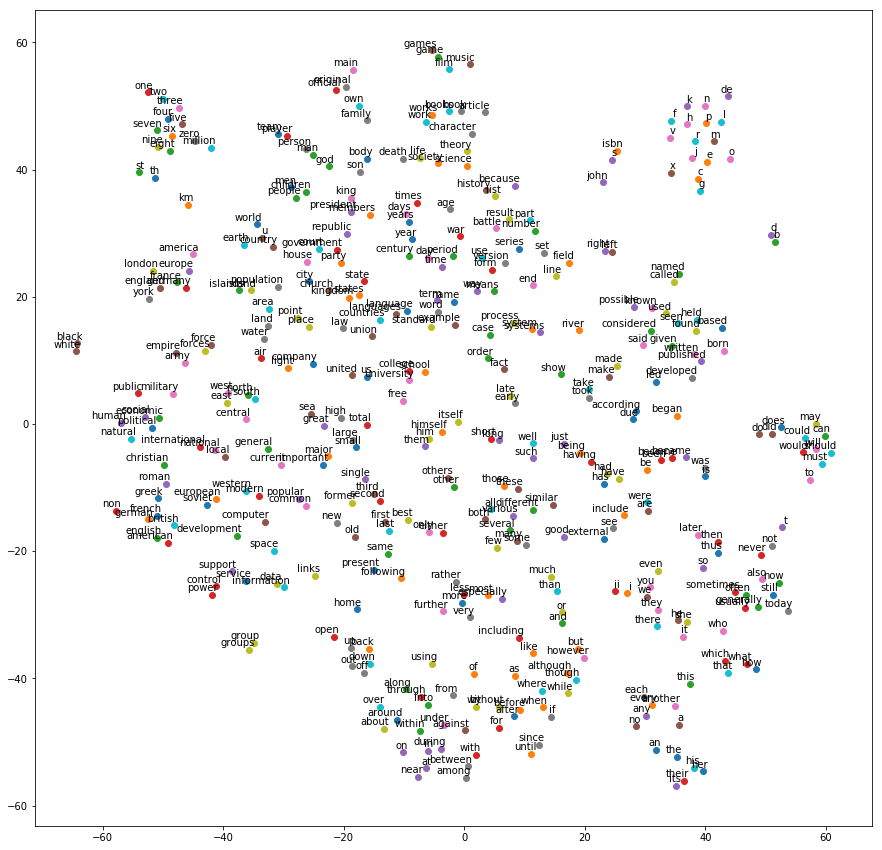

In [52]:
# Plot the 2D output after performing t-SNE for the CBOW model
def plot(embeddings, labels):
  assert embeddings.shape[0] >= len(labels), 'More labels than embeddings'
  pylab.figure(figsize=(15,15))  # in inches
  for i, label in enumerate(labels):
    x, y = embeddings[i,:]
    pylab.scatter(x, y)
    pylab.annotate(label, xy=(x, y), xytext=(5, 2), textcoords='offset points',
                   ha='right', va='bottom')
  pylab.show()

words = [reverse_dictionary[i] for i in range(1, num_points+1)]
plot(two_d_embeddings, words)

Comparison of CBOW output to skip-gram output
The CBOW model did appear to train much more quickly than the skip-gram one, which is as expected given CBOW 
has less training data because it uses complete contexts instead of multiple pairs
While the embedding of the CBOW model appears very different to that of skip-gram, they both seem equally accurate upon visual inspection. Similar words are indeed clustered close together in both methods (eg. numbers like one, two, three, etc. colors like black and white). 
Given this, it seems that the CBOW model is better for this dataset since it trained more quickly